# TF Lite Conversion Comparison

This page provide a guidance of using TFLite to convert and deploy models.

We use LeNet-like CNN model on MNIST dataset.  The workflow is general, however the performance of TF Lite model (compression, accuracy) would be different based your models and datasets.

<!-- TEASER_END -->
Specifically, I am going to explain the workflow buried in Tensorflow Lite webpage

![Lite convert decision map](https://www.tensorflow.org/lite/performance/images/optimization.jpg)



In [0]:
# !pip install -U tensorflow=2.0.0

In [0]:
!rm -rf *.tflite
!mkdir -p tmp
!rm -rf tmp/*.tflite

In [0]:
%tensorflow_version 1.15
from google.colab import files
import tensorflow as tf
from tensorflow import keras
from tensorflow import lite
import numpy as np
import matplotlib.pylab as plt
from packaging import version
from os import path
import pandas as pd
import os
from IPython.core.display import HTML
import time
%matplotlib inline

os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
ver1_flag = version.parse(tf.__version__) < version.parse("2.0")
tf.__version__

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


'1.15.0'

# Load data

Also we create two generator functions, `create_data` and `create_represent_data` for TFLite usage later.


In [0]:
# load mnist data for testing

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(10000, 28,28, 1).astype('float32') / 255
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

def create_data(data):
  def data_gen():
    for i in data:
      yield [i]
  return data_gen

def create_represent_data(data):
  def data_gen():
    for i in data:
      yield [list([i])]
  return data_gen

x_train.shape

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

# Build Keras Model

We build a simple CNN model for testing.

In [0]:
keras.backend.clear_session()
m = keras.Sequential([
                       keras.layers.Conv2D(16, 3, activation='relu', input_shape=(28,28,1)),
                       keras.layers.BatchNormalization(),
                       keras.layers.MaxPool2D(),
                       keras.layers.Conv2D(16, 3, activation='relu'),
                       keras.layers.BatchNormalization(),
                       keras.layers.MaxPool2D(),
                       keras.layers.Flatten(),
                       keras.layers.Dense(128, activation='relu'),
                       keras.layers.Dense(10, activation='softmax', )
])

m.compile(optimizer=keras.optimizers.Adam(),
          loss=keras.losses.SparseCategoricalCrossentropy(),
          metrics=[keras.metrics.SparseCategoricalAccuracy()])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
if path.isfile("model.h5"):  # try to avoid train again, load model if present
  m = keras.models.load_model("model.h5")
  m.compile(optimizer=keras.optimizers.Adam(),
          loss=keras.losses.SparseCategoricalCrossentropy(),
          metrics=[keras.metrics.SparseCategoricalAccuracy()])
else:
  m.fit(x_train, y_train, batch_size=128, epochs=10)
  m.save("model.h5")

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 39s 647us/sample - loss: 0.1670 - sparse_categorical_accuracy: 0.9497
Epoch 2/10
60000/60000 [==============================] - 37s 622us/sample - loss: 0.0486 - sparse_categorical_accuracy: 0.9854
Epoch 3/10
60000/60000 [==============================] - 37s 622us/sample - loss: 0.0328 - sparse_categorical_accuracy: 0.9900
Epoch 4/10
60000/60000 [==============================] - 40s 663us/sample - loss: 0.0237 - sparse_categorical_accuracy: 0.9926
Epoch 5/10
60000/60000 [==============================] - 39s 652us/sample - loss: 0.0188 - sparse_categorical_accuracy: 0.9940
Epoch 6/10
60000/60000 [==============================] - 39s 652us/sample - loss: 0.0123 - sparse_categorical_accuracy: 0.9961
Epoch 7/10
60000/60000 [==============================] - 39s 655us/sample - loss: 0.0125 - sparse_categorical_accuracy: 0.9959
Epoch 8/10
60000/60000 [==============================] - 39s 655us/sample - loss

In [0]:
m.evaluate(x_test, y_test)[1] ## accuracy

10000/10000 [==============================] - 3s 289us/sample - loss: 0.0532 - sparse_categorical_accuracy: 0.9867


0.9867

In [0]:
m = keras.models.load_model("model.h5")
plain_res = m.predict(x_test)
plain_res.shape

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(10000, 10)

In [0]:
sum(np.argmax(plain_res, axis=1) == y_test)/len(y_test)  # test accuracy

0.9867

## TF Lite conversion options

In [0]:
def get_conv(model_file):  # create tflite converter for keras model
  """
  Create TFLiteConverter from keras model
  """
  if ver1_flag:
    conv = lite.TFLiteConverter.from_keras_model_file(model_file)
  else: 
    m = keras.models.load_model(model_file)
    conv = lite.TFLiteConverter.from_keras_model(m)
  return conv

In [0]:
def get_diff(result1, result2):
  """
  compute the difference between two results
  """
  assert result1.shape == result2.shape
  id1 = np.argmax(result1, axis=1)
  id2 = np.argmax(result2, axis=1)
  mismatch = sum(id1!=id2)
  diff = result1[id1]-result2[id1]
  return mismatch, diff

def get_res(filename, data_gen):  # get interpreter output
  """
  get output from tflite model
  
  filename - tflite model
  data_gen - generator for data input x
  """
  intp = lite.Interpreter(filename)
  intp.allocate_tensors()
  for i in data_gen():
    intp.set_tensor(intp.get_input_details()[0]['index'], i)
    intp.invoke()
    yield intp.get_tensor(intp.get_output_details()[0]['index'])

def get_acc(filename):
  "get acuracy from tflite model"
  data_gen = create_data(x_test)
  pred = np.squeeze([i for i in get_res(filename, data_gen)])
  return np.sum(np.argmax(pred, axis=1) == y_test) / len(y_test)

def get_res2(filename, data_gen):
  "get accuracy and time"
  intp = lite.Interpreter(filename)
  intp.allocate_tensors()

  for i in data_gen():
    t = time.monotonic()
    intp.set_tensor(intp.get_input_details()[0]['index'], i)
    intp.invoke()
    t = time.monotonic() - t
    yield np.argmax(intp.get_tensor(intp.get_output_details()[0]['index'])), t


def get_acc_and_time(filename):
  data_gen = create_data(x_test)
  pred = np.squeeze([i for i in get_res2(filename, data_gen)])
  return np.sum(pred[:,0]==y_test)/len(y_test), np.mean(pred[:,1]), np.std(pred[:,1])  # acc, mean, std of inference

### Collect *all* options for tflite conversion

In [0]:
# for converter.target_spec.supported_types 
type_choice = {}
if ver1_flag:
    for i in lite.constants.__all__:
        type_choice[i.lower()] = [lite.constants.__dict__[i]]
else:
    from tensorflow.lite.python import lite_constants as constants
    type_choice = {
        "float": [constants.FLOAT],      # tf.float32
        "int8": [constants.INT8],        # tf.int8
        "int32": [constants.INT32],      # tf.int32
        "int64": [constants.INT64],      # tf.int64
        "string": [constants.STRING],    # tf.string
        "uint8": [constants.QUANTIZED_UINT8],  #tf.uint
    }
type_choice['none'] = None   
# for converter.target_spec.supported_ops
ops_choice = {
    "int8": [lite.OpsSet.TFLITE_BUILTINS_INT8],
    "tflite": [lite.OpsSet.TFLITE_BUILTINS],  # default
    "tf": [lite.OpsSet.SELECT_TF_OPS, lite.OpsSet.TFLITE_BUILTINS]
}

opt_choice = {
    "default": [lite.Optimize.DEFAULT], 
    "latency": [lite.Optimize.OPTIMIZE_FOR_LATENCY], 
    "size": [lite.Optimize.OPTIMIZE_FOR_SIZE],
    "none": []
}

# for converter.representative_dataset
data_gen2 = create_represent_data(x_train[:5000])
data_choice = {"with_data": data_gen2, "wo_data": None}

In [0]:
type_choice
# tflite and graphviz_dot are used to control output graph type.

{'float': [tf.float32],
 'float16': [tf.float16],
 'graphviz_dot': [3],
 'int32': [tf.int32],
 'int64': [tf.int64],
 'int8': [tf.int8],
 'none': None,
 'quantized_uint8': [tf.uint8],
 'string': [tf.string],
 'tflite': [2]}

In [0]:
%%capture convert_log
res = []
for xdata in data_choice:
  for xopt in opt_choice:
    for xops in ops_choice:
      for xtype in type_choice:
        filename = "tmp/%s-opt(%s)-ops(%s)-type(%s).tflite"%(xdata, xopt, xops, xtype)
        print("********  %s ********" % filename)
        keras.backend.clear_session()
        try:
          conv = get_conv("model.h5")
          conv.optimizations = opt_choice[xopt]
          conv.representative_dataset = data_choice[xdata]
          conv.target_spec.supported_ops = ops_choice[xops]
          conv.target_spec.supported_types = type_choice[xtype]
          fb = conv.convert()
          msg = ("success")
          with open(filename, 'wb') as f:
            f.write(fb)
          size = path.getsize(filename)
          print("finished")
          acc = get_acc_and_time(filename)
        except Exception as e:
          msg = e.__str__()
          print("failed - %s"%msg)    
          size = None
          acc = None, None, None
        finally:
          res.append([xdata, xopt, xops, xtype, size, msg, *acc])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
INFO:tensorflow:Froze 16 variables.


In [0]:
result = pd.DataFrame(res, columns=["data", "optimization", "ops", "type", "size", "status", "accuracy","mean_inference","std_inference"])
result.to_pickle("result.pkl")

In [0]:
files.download("result.pkl")

In [0]:
%%javascript
require.config({
    paths: {
        DT: '//cdn.datatables.net/1.10.19/js/jquery.dataTables.min',
    }
});

<IPython.core.display.Javascript object>

### Raw results

In [0]:
HTML(result.to_html())

,data,optimization,ops,type,size,status,accuracy,mean_inference,std_inference
0,with_data,default,int8,float,NaN,TFLITE_BUILTINS_INT8 requires smallest supported type to be INT8.,NaN,NaN,NaN
1,with_data,default,int8,float16,NaN,TFLITE_BUILTINS_INT8 requires smallest supported type to be INT8.,NaN,NaN,NaN
2,with_data,default,int8,graphviz_dot,NaN,'int' object has no attribute 'size',NaN,NaN,NaN
3,with_data,default,int8,int32,NaN,TFLITE_BUILTINS_INT8 requires smallest supported type to be INT8.,NaN,NaN,NaN
4,with_data,default,int8,int64,NaN,TFLITE_BUILTINS_INT8 requires smallest supported type to be INT8.,NaN,NaN,NaN
5,with_data,default,int8,int8,60976.0,success,0.9869,0.001737,0.001835
6,with_data,default,int8,quantized_uint8,NaN,TFLITE_BUILTINS_INT8 requires smallest supported type to be INT8.,NaN,NaN,NaN
7,with_data,default,int8,string,NaN,TFLITE_BUILTINS_INT8 requires smallest supported type to be INT8.,NaN,NaN,NaN
8,with_data,default,int8,tflite,NaN,'int' object has no attribute 'size',NaN,NaN,NaN
9,with_data,default,int8,none,60976.0,success,0.9869,0.001721,0.000083


### Finished tf lite models

In [0]:
HTML(result.dropna().to_html())

,data,optimization,ops,type,size,status,accuracy,mean_inference,std_inference
5,with_data,default,int8,int8,60976.0,success,0.9869,0.001737,0.001835
9,with_data,default,int8,none,60976.0,success,0.9869,0.001721,0.000083
10,with_data,default,tflite,float,60976.0,success,0.9869,0.001719,0.000059
11,with_data,default,tflite,float16,114928.0,success,0.9867,0.000301,0.000026
13,with_data,default,tflite,int32,60976.0,success,0.9869,0.001721,0.000060
14,with_data,default,tflite,int64,60976.0,success,0.9869,0.001719,0.000059
15,with_data,default,tflite,int8,60976.0,success,0.9869,0.001718,0.000060
16,with_data,default,tflite,quantized_uint8,60976.0,success,0.9869,0.001722,0.000087
17,with_data,default,tflite,string,60976.0,success,0.9869,0.001718,0.000059
19,with_data,default,tflite,none,60976.0,success,0.9869,0.001744,0.002122


## TF Lite Interpreter result details

In [0]:
data_gen = create_data(x_test)

### Plain TF Lite Convert




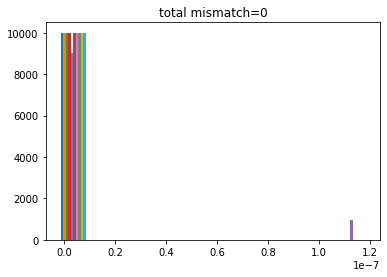

In [0]:
plain_tflite = np.squeeze([i for i in get_res("tmp/wo_data-opt(none)-ops(tf)-type(float).tflite", data_gen)])
mismatch, diff = get_diff(plain_res, plain_tflite)
plt.hist(diff)
plt.title("total mismatch=%d"%mismatch)
plt.show()

In [0]:
def print_inpt(filename):
  intp = lite.Interpreter(filename)
  for i in intp.get_tensor_details():
    print("\t".join(["%d"%i['index'], ("%s"%i['dtype']).split("'")[1].split('.')[1], i['name'], "%s"%i['shape'], "(%f,%f)"%i['quantization']]))

In [0]:
print_inpt("tmp/wo_data-opt(none)-ops(tf)-type(float).tflite")

0	float32	batch_normalization/FusedBatchNormV3	[ 1 26 26 16]	(0.000000,0.000000)
1	float32	batch_normalization/FusedBatchNormV3_add_param	[16]	(0.000000,0.000000)
2	float32	batch_normalization/FusedBatchNormV3_mul_0	[ 1 26 26 16]	(0.000000,0.000000)
3	float32	batch_normalization/FusedBatchNormV3_mul_0_param	[16]	(0.000000,0.000000)
4	float32	batch_normalization_1/FusedBatchNormV3	[ 1 11 11 16]	(0.000000,0.000000)
5	float32	batch_normalization_1/FusedBatchNormV3_add_param	[16]	(0.000000,0.000000)
6	float32	batch_normalization_1/FusedBatchNormV3_mul_0	[ 1 11 11 16]	(0.000000,0.000000)
7	float32	batch_normalization_1/FusedBatchNormV3_mul_0_param	[16]	(0.000000,0.000000)
8	float32	conv2d/Conv2D_bias	[16]	(0.000000,0.000000)
9	float32	conv2d/Relu	[ 1 26 26 16]	(0.000000,0.000000)
10	float32	conv2d/kernel	[ 1  3  3 16]	(0.000000,0.000000)
11	float32	conv2d_1/Conv2D_bias	[16]	(0.000000,0.000000)
12	float32	conv2d_1/Relu	[ 1 11 11 16]	(0.000000,0.000000)
13	float32	conv2d_1/kernel	[16  3  3 16

### TF default optimization

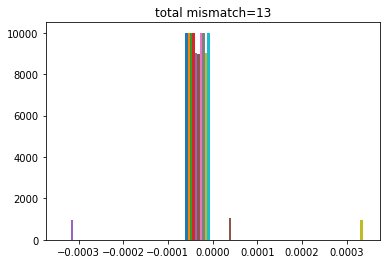

In [0]:
plain_opt = np.squeeze([i for i in get_res("tmp/wo_data-opt(default)-ops(tflite)-type(float).tflite", data_gen)])
mismatch, diff = get_diff(plain_res, plain_opt)
plt.hist(diff)
plt.title("total mismatch=%d"%mismatch)
plt.show()

In [0]:
print_inpt("tmp/wo_data-opt(default)-ops(tflite)-type(float).tflite")

0	float32	batch_normalization/FusedBatchNormV3	[ 1 26 26 16]	(0.000000,0.000000)
1	float32	batch_normalization/FusedBatchNormV3_add_param	[16]	(0.000000,0.000000)
2	float32	batch_normalization/FusedBatchNormV3_mul_0	[ 1 26 26 16]	(0.000000,0.000000)
3	float32	batch_normalization/FusedBatchNormV3_mul_0_param	[16]	(0.000000,0.000000)
4	float32	batch_normalization_1/FusedBatchNormV3	[ 1 11 11 16]	(0.000000,0.000000)
5	float32	batch_normalization_1/FusedBatchNormV3_add_param	[16]	(0.000000,0.000000)
6	float32	batch_normalization_1/FusedBatchNormV3_mul_0	[ 1 11 11 16]	(0.000000,0.000000)
7	float32	batch_normalization_1/FusedBatchNormV3_mul_0_param	[16]	(0.000000,0.000000)
8	float32	conv2d/Conv2D_bias	[16]	(0.000000,0.000000)
9	float32	conv2d/Relu	[ 1 26 26 16]	(0.000000,0.000000)
10	float32	conv2d/kernel	[ 1  3  3 16]	(0.000000,0.000000)
11	float32	conv2d_1/Conv2D_bias	[16]	(0.000000,0.000000)
12	float32	conv2d_1/Relu	[ 1 11 11 16]	(0.000000,0.000000)
13	int8	conv2d_1/kernel	[16  3  3 16]	(

### TF with representative data

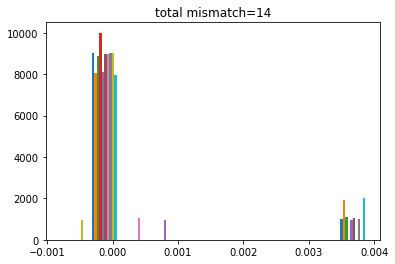

In [0]:
data_opt = np.squeeze([i for i in get_res("tmp/with_data-opt(default)-ops(tflite)-type(float).tflite", data_gen)])
mismatch, diff = get_diff(plain_res, data_opt)
plt.hist(diff)
plt.title("total mismatch=%d"%mismatch)
plt.show()

In [0]:
print_inpt("tmp/with_data-opt(default)-ops(tflite)-type(float).tflite")

0	int8	batch_normalization/FusedBatchNormV3	[ 1 26 26 16]	(0.043397,-107.000000)
1	int8	batch_normalization/FusedBatchNormV3_add_param	[16]	(0.007060,0.000000)
2	int8	batch_normalization/FusedBatchNormV3_mul_0	[ 1 26 26 16]	(0.041571,-128.000000)
3	int8	batch_normalization/FusedBatchNormV3_mul_0_param	[16]	(0.239892,0.000000)
4	int8	batch_normalization_1/FusedBatchNormV3	[ 1 11 11 16]	(0.078118,-119.000000)
5	int8	batch_normalization_1/FusedBatchNormV3_add_param	[16]	(0.005670,0.000000)
6	int8	batch_normalization_1/FusedBatchNormV3_mul_0	[ 1 11 11 16]	(0.077301,-128.000000)
7	int8	batch_normalization_1/FusedBatchNormV3_mul_0_param	[16]	(0.021564,0.000000)
8	int32	conv2d/Conv2D_bias	[16]	(0.000000,0.000000)
9	int8	conv2d/Relu	[ 1 26 26 16]	(0.002887,-128.000000)
10	int8	conv2d/kernel	[ 1  3  3 16]	(0.000000,0.000000)
11	int32	conv2d_1/Conv2D_bias	[16]	(0.000000,0.000000)
12	int8	conv2d_1/Relu	[ 1 11 11 16]	(0.039788,-128.000000)
13	int8	conv2d_1/kernel	[16  3  3 16]	(0.000000,0.000000)


### Other quick comparison

In [0]:
print_inpt("tmp/with_data-opt(default)-ops(int8)-type(int8).tflite")

0	int8	batch_normalization/FusedBatchNormV3	[ 1 26 26 16]	(0.043397,-107.000000)
1	int8	batch_normalization/FusedBatchNormV3_add_param	[16]	(0.007060,0.000000)
2	int8	batch_normalization/FusedBatchNormV3_mul_0	[ 1 26 26 16]	(0.041571,-128.000000)
3	int8	batch_normalization/FusedBatchNormV3_mul_0_param	[16]	(0.239892,0.000000)
4	int8	batch_normalization_1/FusedBatchNormV3	[ 1 11 11 16]	(0.078118,-119.000000)
5	int8	batch_normalization_1/FusedBatchNormV3_add_param	[16]	(0.005670,0.000000)
6	int8	batch_normalization_1/FusedBatchNormV3_mul_0	[ 1 11 11 16]	(0.077301,-128.000000)
7	int8	batch_normalization_1/FusedBatchNormV3_mul_0_param	[16]	(0.021564,0.000000)
8	int32	conv2d/Conv2D_bias	[16]	(0.000000,0.000000)
9	int8	conv2d/Relu	[ 1 26 26 16]	(0.002887,-128.000000)
10	int8	conv2d/kernel	[ 1  3  3 16]	(0.000000,0.000000)
11	int32	conv2d_1/Conv2D_bias	[16]	(0.000000,0.000000)
12	int8	conv2d_1/Relu	[ 1 11 11 16]	(0.039788,-128.000000)
13	int8	conv2d_1/kernel	[16  3  3 16]	(0.000000,0.000000)


In [0]:
print_inpt("tmp/with_data-opt(size)-ops(tflite)-type(int8).tflite")

0	int8	batch_normalization/FusedBatchNormV3	[ 1 26 26 16]	(0.043397,-107.000000)
1	int8	batch_normalization/FusedBatchNormV3_add_param	[16]	(0.007060,0.000000)
2	int8	batch_normalization/FusedBatchNormV3_mul_0	[ 1 26 26 16]	(0.041571,-128.000000)
3	int8	batch_normalization/FusedBatchNormV3_mul_0_param	[16]	(0.239892,0.000000)
4	int8	batch_normalization_1/FusedBatchNormV3	[ 1 11 11 16]	(0.078118,-119.000000)
5	int8	batch_normalization_1/FusedBatchNormV3_add_param	[16]	(0.005670,0.000000)
6	int8	batch_normalization_1/FusedBatchNormV3_mul_0	[ 1 11 11 16]	(0.077301,-128.000000)
7	int8	batch_normalization_1/FusedBatchNormV3_mul_0_param	[16]	(0.021564,0.000000)
8	int32	conv2d/Conv2D_bias	[16]	(0.000000,0.000000)
9	int8	conv2d/Relu	[ 1 26 26 16]	(0.002887,-128.000000)
10	int8	conv2d/kernel	[ 1  3  3 16]	(0.000000,0.000000)
11	int32	conv2d_1/Conv2D_bias	[16]	(0.000000,0.000000)
12	int8	conv2d_1/Relu	[ 1 11 11 16]	(0.039788,-128.000000)
13	int8	conv2d_1/kernel	[16  3  3 16]	(0.000000,0.000000)


## Remarks

### Take-aways

+ No data, no optimization, ops and types doesn't matter (except using int8/uint8 will crash).  It will create a float32 tflite for runtime.
+ With optimization (and without float16), some weights are quantized to int8.
+ With data and optimization, weights are in int type. However int8 is not strictly enforced.
+ When ops is `int8`, data type needs to be `int8`.

### Remaining mysterious

+ What's the difference between `select` and `builtin`?
+ What's the `string` or `none` op type?


## An unexpected problem

If you check the source code](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/kernels/kernel_util.cc#L100), it is under the `GetQuantizedConvolutionMultipler` function.  So there is some interesting conversion for the fully connected layer.  To save the trouble and focus on our original goal.  

In [0]:
m = keras.Sequential(
    [keras.layers.Dense(100, input_shape=(5,)),
     keras.layers.Dense(100),
     keras.layers.Dense(3)]
)
m.save("model2.h5")
x = np.random.randn(100,5).astype('float32')

def data_gen():
  for i in range(100):
    yield x[None, i]

def data_gen2():
  y = data_gen()
  for i in y:
    yield [list(i)]

if ver1_flag:
  conv = lite.TFLiteConverter.from_keras_model_file("model2.h5")
else: 
  conv = lite.TFLiteConverter.from_keras_model(m)
conv.optimizations = [lite.Optimize.DEFAULT]
conv.representative_dataset = data_gen2
with open("problem.tflite", "wb") as f:
  f.write(conv.convert())


INFO:tensorflow:Froze 6 variables.


INFO:tensorflow:Froze 6 variables.


INFO:tensorflow:Converted 6 variables to const ops.


INFO:tensorflow:Converted 6 variables to const ops.


In [0]:
intp = lite.Interpreter("problem.tflite")
intp.allocate_tensors()

RuntimeError: ignored